## NX-414: Brain-like computation and intelligence
Notebook prepared by Alessandro Marin Vargas

# Week 6 - Mini project (Predicting neural activity)

The objectives of the mini project are:
- Learn how to predict neural activity using linear regression from images and from neural network layers.
- Quantify the goodness of the model
- Compare the results across the network layers and between trained/random neural network
- Predict the neural activity using a neural network in a data-driven approach

Specifically, here you will use the data from the following [paper](https://www.jneurosci.org/content/jneuro/35/39/13402.full.pdf). The behavioral experiment consisted in showing to non-human primates some images while recording the neural activity with multielectrode arrays from the inferior temporal (IT) cortex. In the data we provided you, the neural activity and the images are already pre-processed and you will have available the images and the corresponding average firing rate (between 70 and 170 ms) per each neuron.

### Deadline for Mini-Project Submission: May 7, 2025

You are required to submit your mini-projects by midnight on 07/05/25. Please upload a .zip file to Moodle containing your code, along with the following specific components:

- One-Page Report (Report.pdf): This should detail your investigative process and include:
    - A comparison table of models. This should cover linear regression from stimuli, both trained and random task-driven models, data-driven models, and your best-performing model.
    - A figure illustrating the variation in neural prediction across different layers of a task-driven model.
    - Your exploration to develop the most effective model at predicting IT neural activity
- Example Script/Notebook: Please provide a script (test.py) or a notebook (test.ipynb) demonstrating how your best model performs on the validation set. This should serve as an example of the model's usage.

In [1]:
import sys
!{sys.executable} -m pip install gdown h5py

In [5]:
from utils import load_it_data, visualize_img
import matplotlib.pyplot as plt
import numpy as np
import gdown

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import explained_variance_score, r2_score

url = "https://drive.google.com/file/d/1s6caFNRpyR9m7ZM6XEv_e8mcXT3_PnHS/view?usp=share_link"
output = "IT_data.h5"
# gdown.download(url, output, quiet=False, fuzzy=True)

Downloading...
From (original): https://drive.google.com/uc?id=1s6caFNRpyR9m7ZM6XEv_e8mcXT3_PnHS
From (redirected): https://drive.google.com/uc?id=1s6caFNRpyR9m7ZM6XEv_e8mcXT3_PnHS&confirm=t&uuid=f9d33249-cecd-4968-a44e-b5260524a534
To: c:\Users\karim\OneDrive\Desktop\EPFL_Master\Semester4\NX-414 Brain Like Computation and Intelligence\Project\BLCI_G21\IT_data.h5
100%|██████████| 384M/384M [00:20<00:00, 18.5MB/s] 


'IT_data.h5'

### Load the data

In [6]:
path_to_data = '' ## Insert the folder where the data is, if you download in the same folder as this notebook then leave it blank

stimulus_train, stimulus_val, stimulus_test, objects_train, objects_val, objects_test, spikes_train, spikes_val = load_it_data(path_to_data)


In [7]:
n_stimulus, n_channels, img_size, _ = stimulus_train.shape
_, n_neurons = spikes_train.shape
print('The train dataset contains {} stimuli and {} IT neurons'.format(n_stimulus,n_neurons))
print('Each stimulus have {} channgels (RGB)'.format(n_channels))
print('The size of the image is {}x{}'.format(img_size,img_size))

print(stimulus_train.shape)
print(spikes_train.shape)

The train dataset contains 2592 stimuli and 168 IT neurons
Each stimulus have 3 channgels (RGB)
The size of the image is 224x224
(2592, 3, 224, 224)
(2592, 168)


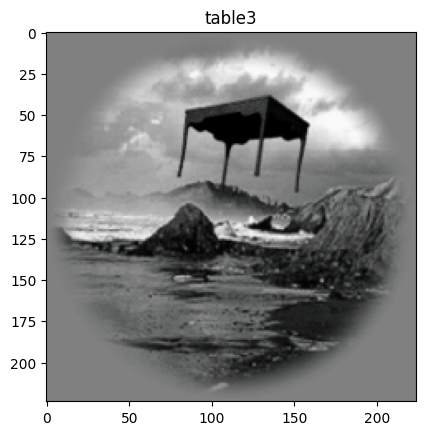

In [8]:
stim_idx = 1

visualize_img(stimulus_train,objects_train,stim_idx)

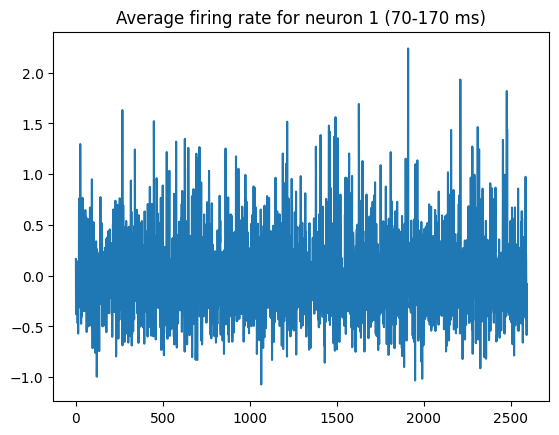

In [9]:
neuron_idx = 1

plt.figure()
plt.title('Average firing rate for neuron {} (70-170 ms)'.format(neuron_idx))
plt.plot(spikes_train[:,neuron_idx])

## Part 1: Predict the neural activity from pixels

##### Develop a linear regression model that predict the neural activity from pixels.
You can try out different types of linear regression (ridge, least-square regression)

In [31]:
#### Reshape the input
stimulus_train_reshape = stimulus_train.reshape(n_stimulus, n_channels * img_size * img_size)
stimulus_val_reshape = stimulus_val.reshape(stimulus_val.shape[0], n_channels * img_size * img_size)
stimulus_test_reshape = stimulus_test.reshape(stimulus_test.shape[0], n_channels * img_size * img_size)

In [32]:
# Linear regression on train
linear_regression = LinearRegression()
linear_regression.fit(stimulus_train_reshape, spikes_train)
predictions_train = linear_regression.predict(stimulus_train_reshape)
predictions_val = linear_regression.predict(stimulus_val_reshape)




Linear regression on train
Train explained variance score: 0.9999999528129896
Train r2 score: 0.9999999656425878
Validation explained variance score: -1.1615340191693533
Validation r2 score: -1.1712278580022808


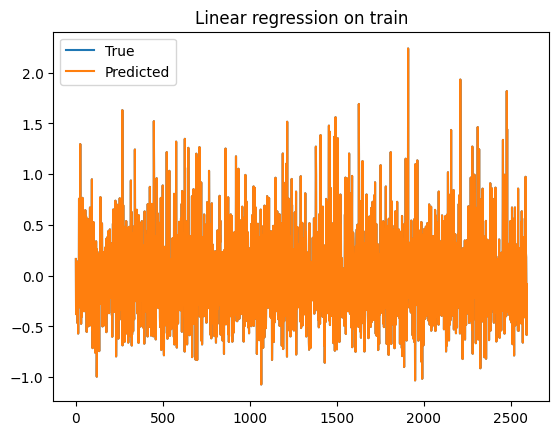

In [33]:
# Inspect
print('Linear regression on train')
print('Train explained variance score: {}'.format(explained_variance_score(spikes_train, predictions_train)))
print('Train r2 score: {}'.format(r2_score(spikes_train, predictions_train)))
print('Validation explained variance score: {}'.format(explained_variance_score(spikes_val, predictions_val)))
print('Validation r2 score: {}'.format(r2_score(spikes_val, predictions_val)))

plt.figure()
plt.title('Linear regression on train')
plt.plot(spikes_train[:, neuron_idx], label='True')
plt.plot(predictions_train[:, neuron_idx], label='Predicted')
plt.legend()
plt.show()

In [ ]:
import pickle
filename = 'simple_linear_non_reg.sav'
pickle.dump(linear_regression, open(filename, 'wb'))

##### Evaluate your prediction (Check both the correlation and explained variance for each neuron). Plot the distribution for the explained variance across neurons.

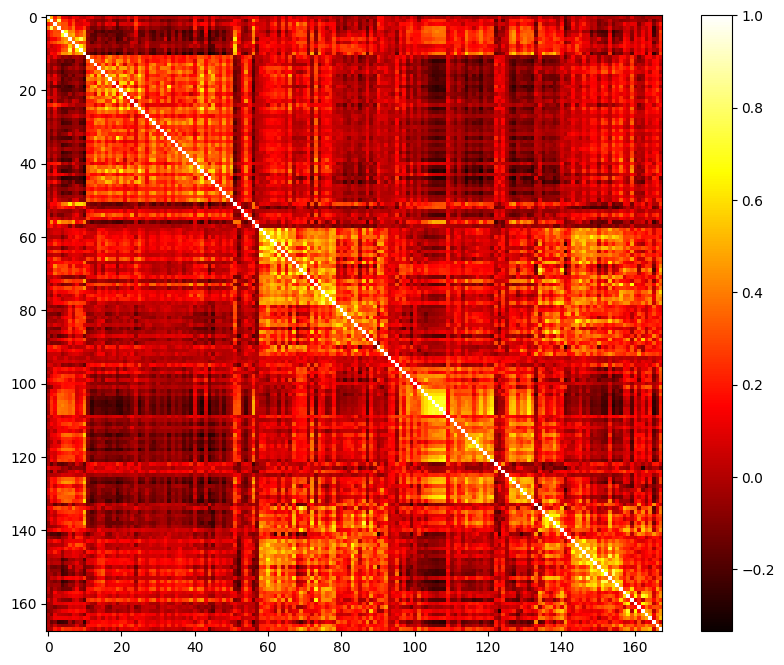

In [37]:
#### Here your code\
# correlate the neurons of the model with each other and plot the correlation matrix
# compute the correlation matrix
correlation_matrix = np.corrcoef(predictions_train.T)
# plot the correlation matrix
plt.figure(figsize=(10, 8))
plt.imshow(correlation_matrix, cmap='hot', interpolation='nearest')
# show the correlation matrix numberline for the colors
plt.colorbar()



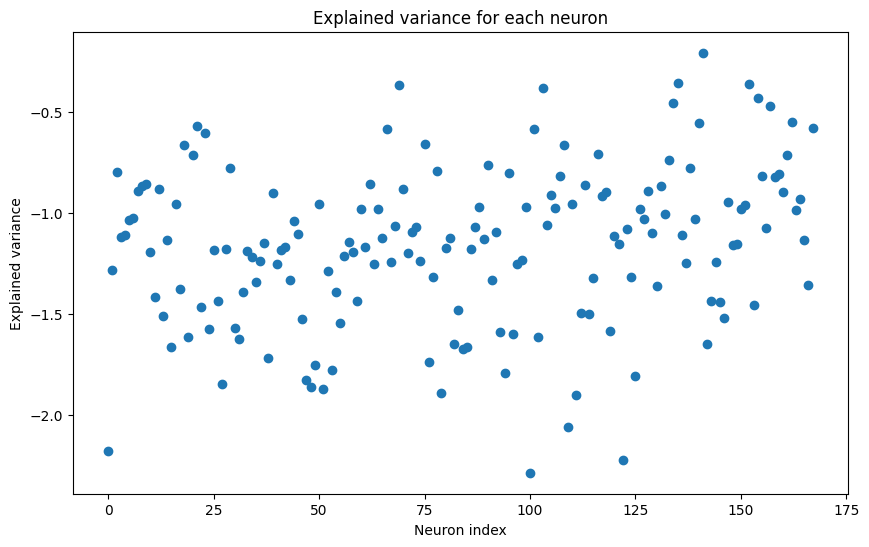

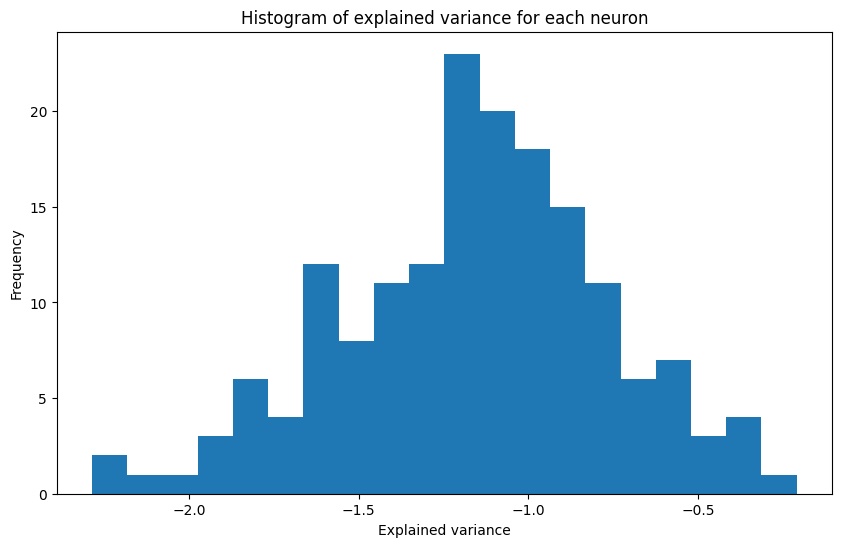

In [38]:
# # print the explained variance for each neuron
# print('Explained variance for each neuron:')
# for i in range(n_neurons):
#     print('Neuron {}: {}'.format(i, explained_variance_score(spikes_train[:, i], predictions_train[:, i])))
    
# plot the explained variance for each neuron
plt.figure(figsize=(10, 6))
plt.scatter(range(n_neurons), [explained_variance_score(spikes_val[:, i], predictions_val[:, i]) for i in range(n_neurons)])
plt.xlabel('Neuron index')
plt.ylabel('Explained variance')
plt.title('Explained variance for each neuron')
plt.show()

# plot the histogram to bin the explained variance
plt.figure(figsize=(10, 6))
plt.hist([explained_variance_score(spikes_val[:, i], predictions_val[:, i]) for i in range(n_neurons)], bins=20)
plt.xlabel('Explained variance')
plt.ylabel('Frequency')
plt.title('Histogram of explained variance for each neuron')
plt.show()


##### Predicting from pixels is very hard and the model is likely to overfit. An image is very high-dimensional, try to retain the corresponding 1000 PCs and use them to predict the neural activity. 

In [39]:
#### Here your code
# Apply PCA to the training data to reduce dimensionality of every image down to 1000 components
pca = PCA(n_components=1000)
pca.fit(stimulus_train_reshape)
# Transform the training, validation and test data
stimulus_train_pca = pca.transform(stimulus_train_reshape)
stimulus_val_pca = pca.transform(stimulus_val_reshape)
stimulus_test_pca = pca.transform(stimulus_test_reshape)
# Check the shape of the PCA transformed data
print(stimulus_train_pca.shape)
print(stimulus_val_pca.shape)

(2592, 1000)
(288, 1000)


In [42]:
# apply normal logistic regression to the PCA transformed data
linear_regression_pca = LinearRegression()
linear_regression_pca.fit(stimulus_train_pca, spikes_train)
predictions_train_pca = linear_regression_pca.predict(stimulus_train_pca)
predictions_val_pca = linear_regression_pca.predict(stimulus_val_pca)
# Inspect
print('Linear regression on PCA train')
print('Train explained variance score: {}'.format(explained_variance_score(spikes_train, predictions_train_pca)))
print('Train r2 score: {}'.format(r2_score(spikes_train, predictions_train_pca)))
print('Validation explained variance score: {}'.format(explained_variance_score(spikes_val, predictions_val_pca)))
print('Validation r2 score: {}'.format(r2_score(spikes_val, predictions_val_pca)))

Linear regression on PCA train
Train explained variance score: 0.461658585639227
Train r2 score: 0.4616586073017185
Validation explained variance score: -0.08038374852566492
Validation r2 score: -0.08425240771812621


##### Can we improve the prediction? Using the ridge regression, find the best parameter with cross-fold validation (remember to split the data keeping the same distribution of classes between the train and validation set). Does it get better?

In [43]:
#### Here your code
# Perform ridge regression on the PCA transformed training data using cross-validation to find the best alpha value
ridge = Ridge()
alphas = np.logspace(-4, 4, 100)
param_grid = {'alpha': alphas}

### Part 2: Predict the neural activity with the task-driven modeling approach

As you have seen in the class, the underlying hypothesis of task-driven modeling is that training the network to perform a relevant behavioral task makes the network to develop representations that resemble the ones of the biological brain. Let's test this hypothesis by loading a pre-trained ResNet50 model and use the activations of each layer to predict the neural activity. Follow these steps:

- Give as input to the network the stimuli and extract the corresponding activations of the following layers ['conv1','layer1','layer2','layer3','layer4','avgpool']
- Compute the 1000 PCs for each layer activation. (Careful that you don't want to store all activations together at the same time because it won't fit in the memory. Therefore, compute the activations and corresponding PCs for each layer and store only the computed PCs).
- Use the PCs of each layer to predict the neural activity using the linear regression models you developed before.
- Compute the goodness of fit using the correlation and explained variance metrics. Do you predict the neural activity better than before?
- Plot the distribution of explained variance with respect to the layer of the network (order them based on the depth). How does the neural activity changes across the model layers, can you make some statements about it?
- Compare the predictions that you obtained using one layer of the pretrained model and the one obtained using the same layer but from a randomly initialized model. Which network can better predict the neural activity and why?

In [ ]:
# download keras 
!{sys.executable} -m pip install keras tensorflow

In [ ]:
#### Here your code
# Get a pretrained resnet50 model
from keras.applications import ResNet50
from keras.models import Model
